# Rigid rods

This example demonstrates how to constrain particles in rigid bodies.

## Initialize

Import the hoomd python package.

In [1]:
import itertools
import math
import numpy
import gsd
import gsd.hoomd
import hoomd

The center of mass of each rigid body must be present in the system as a particle. The type assigned to this particle must be unique to all such center of mass particles for rigid bodies with the same geometry. The position and orientation of the center of mass particle, together with a definition of the local environment of the body define where all constituent particles should be placed. Constituent particles are also particles in the system.

First, create two planes of the center of mass particles. These particles define the mass and moment of inertia of the rigid body.

In [2]:
m = 18
N_particles = 2 * m**2
L = 22
x = numpy.linspace(-L / 2, L / 2, m, endpoint=False)
plane_position = list(itertools.product(x, repeat=2))
position = [(x,y,z) for x in (-L / 4, L / 4) for y,z in plane_position ]

snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N_particles
snapshot.particles.position = position[0:N_particles]
snapshot.particles.typeid = [0]*N_particles
snapshot.configuration.box = [L, L, L, 0, 0, 0]
snapshot.particles.types = ['R']
snapshot.particles.moment_inertia = [[0, 1/12*8**2, 1/12*8**2]] * N_particles
snapshot.particles.orientation = [[1, 0, 0, 0]] * N_particles

This only creates the center of mass particles (type *R*).

Examine how the system configuration: [ex_render](ex_render.py) is a helper script that builds animated gifs from trajectory files and system snapshots. It is part of the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository and designed only to render these examples.

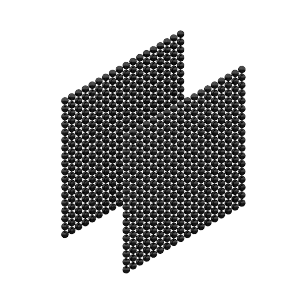

In [3]:
import ex_render
ex_render.render_sphere_frame(snapshot)

``md.constrain.Rigid`` applies the rigid constraint to all the constituent particles, and can also create the constituent particles in the system.

Add the particle type for the constituent particles. Constituents may not share a type with any rigid central particle.

In [4]:
snapshot.particles.types.append('A')

Initialize the `Simulation` object and set HOOMD execute the simulation on the cpu.

In [5]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu)

In [6]:
integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell()

lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)

nvt = hoomd.md.methods.NVT(kT=1.5, filter=hoomd.filter.All(), tau=1.0)
integrator.methods.append(nvt)

In [7]:
sim.create_state_from_snapshot(snapshot)
sim.operations.integrator = integrator
#sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5, seed=1)

AttributeError: 'Snapshot' object has no attribute '_broadcast_box'

Define each rigid body type in the local coordinate system of the body. This example creates rods 9 particles long. The center of mass particle is at ``(0,0,0)`` and the constituent particles extend to either side.

Recall that the moment of inertia was specified as a length 3 vector [Ix, Iy, Iz]. The positions of the particles in the local reference frame must be such that the moment of inertia tensor is diagonal. The actual values specified need not assume anything about the body, such as point particles - HOOMD takes the moment of inertia as given and uses it directly in the equations of motion. Above, these bodies are initialized as if they are ideal line segments of length 8.

In [ ]:
rigid = hoomd.md.constrain.Rigid()
rigid.set_param('R', 
                types=['A']*8,
                positions=[(-4,0,0),(-3,0,0),(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0),(3,0,0),(4,0,0)]);

Instruct the rigid constraint to create the constituent particles.

In [ ]:
rigid.create_bodies()

Now, the rods are complete.

In [ ]:
import ex_render
ex_render.render_sphere_frame(system.take_snapshot())

## Define the potential energy

The WCA potential has the same functional form as Lennard-Jones, but $r_\mathrm{cut}=2^{1/6}\sigma$ and is shifted up to 0 at the cutoff.

Choose the neighbor list acceleration structure to find neighboring particles efficiently. In systems with only one cutoff length, the cell method performs best.

In [ ]:
nl = hoomd.md.nlist.cell()

Define the functional form of the pair interaction and evaluate using the given neighbor list acceleration structure.

In [ ]:
lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)
lj.set_params(mode='shift')

Specify pair potential parameters for every pair of types in the simulation. The particle types *R* and *A* exist in the system for the rigid bodies, but both should interact identically. The *R* particle in the center of the rod is a part of the rod.

In [ ]:
lj.pair_coeff.set(['R', 'A'], ['R', 'A'], epsilon=1.0, sigma=1.0)

## Select integrator

The integrator defines the equations of motion that govern the system of particles, given the current configuration of the particles and the net force from all potentials. The standard integration mode in HOOMD allows different integrators to apply to different groups of particles with the same step size $dt$.

In [ ]:
hoomd.md.integrate.mode_standard(dt=0.005);

Apply the Langevin equations of motion to all the rigid center of mass particles. $kT$ defines the temperature of the system in energy units and *seed* defines the seed for the random number generator. If there were non-rigid particles in this system, the same integrator could apply to both. Do **not** apply an integrator to constituent particles.

In [ ]:
rigid = hoomd.group.rigid_center();
hoomd.md.integrate.langevin(group=rigid, kT=1.0, seed=42);

## Write output

Periodically log the potential energy of the system to a text file.

In [ ]:
hoomd.analyze.log(filename="log-output.log",
                  quantities=['potential_energy',
                              'translational_kinetic_energy',
                              'rotational_kinetic_energy'],
                  period=100,
                  overwrite=True);

Periodically write the particle configurations to a gsd file.

In [ ]:
hoomd.dump.gsd("trajectory.gsd",
               period=2e3,
               group=hoomd.group.all(),
               overwrite=True);     

## Run the simulation

Take 10,000 steps forward in time.

In [ ]:
hoomd.run(1e4);

## Examine the output

Use matplotlib to plot the potential energy vs time step.

In [ ]:
import numpy
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);

In [ ]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,1]);
pyplot.xlabel('time step');
pyplot.ylabel('potential_energy');

Notice that the average rotational kinetic energy is 2/3 of the translational. This is consistent with the equipartition theorem: the rods have 3 translational degrees of freedom but only 2 rotational ones. HOOMD determined the number of rotational degrees of freedom from the moment of inertia tensor provided during initialization. The 0 moment of inertia about *x* notified HOOMD that the bodies should not rotate about that axis.

In [ ]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,2]);
pyplot.plot(data[:,0], data[:,3]);
pyplot.xlabel('time step');
pyplot.ylabel('kinetic_energy');
pyplot.legend(['translational', 'rotational'], loc='lower right');

In [ ]:
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory.gsd');